In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from wfdb import processing

import data_visualisation as dv

In [2]:
channels = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6", "V1R"]

# UHF

In [3]:
# get uhf bin files
files_positive = [f for f in os.listdir('Brugada AI ECG test set/BrS +ve/') if f.endswith('.bin')]
file_paths_positive = ['Brugada AI ECG test set/BrS +ve/' + f for f in files_positive]

# get folders in -ve folder
folders_negative = [f for f in os.listdir('Brugada AI ECG test set/BrS -ve/') if not f.endswith('.bin') and not f.endswith('.txt')]
# get .bin from each folder
files_negative = []
file_paths_negative = []
for folder in folders_negative:
    
    folder_files = [f for f in os.listdir('Brugada AI ECG test set/BrS -ve/' + folder) if f.endswith('.bin')]
    files_negative += folder_files
    file_paths_negative += ['Brugada AI ECG test set/BrS -ve/' + folder + '/' + f for f in folder_files]


print('Positive files:', files_positive)
print('Negative paths:', file_paths_negative)
print('Negative files:', files_negative)

Positive files: ['BRS41__20240725_215658.bin', 'BRS25__20240328_125450.bin', 'IS6__20231218_131703.bin', 'KS5__20231211_122437.bin', 'BRS44__20240809_102517.bin', 'BRS5__20231204_133041.bin', 'BRS42__20240725_232404.bin', 'BRS26__20240327_161440.bin', 'BRS43__20240801_162559.bin']
Negative paths: ['Brugada AI ECG test set/BrS -ve/af1_20231123_162100/af1__20231123_162100.bin', 'Brugada AI ECG test set/BrS -ve/N5_5_20240604_120935/N55__20240604_120935.bin', 'Brugada AI ECG test set/BrS -ve/LL1_20240528_103006/LL1__20240528_103006.bin', 'Brugada AI ECG test set/BrS -ve/N8_20240415_123644/N8__20240415_123644.bin', 'Brugada AI ECG test set/BrS -ve/HVLW1_20240531_123839/HVLW1__20240531_123839.bin', 'Brugada AI ECG test set/BrS -ve/N17_20240422_140721/N17__20240422_140721.bin', 'Brugada AI ECG test set/BrS -ve/P45_20240606_115708/P45__20240606_115708.bin', 'Brugada AI ECG test set/BrS -ve/N25_20240429_134539/N25__20240429_134539.bin', 'Brugada AI ECG test set/BrS -ve/HVTS1_20240610_094430/HVT

In [4]:
# Define the bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

In [7]:
def load_uhf_ecg_data(filepath):
    #load 
    with open(filepath, "rb") as f:
        data = f.read()
    data = np.frombuffer(data, dtype=np.float32)
    
    # reshape data to 2D array with 57 channels
    data = data.reshape(-1, 57)
    
    # get rid of all channels excpet first 13
    data = data[:, :13]
    
    # remove wilson lead
    data = np.delete(data, 6, axis=1)
    
    # Filter parameters
    lowcut = 0.5
    highcut = 150.0
    fs = 5000
    
    # Apply the filter
    filtered_ecg_data = bandpass_filter(data, lowcut, highcut, fs)
    
    # truncate by nearest N + downsample
    filtered_ecg_data = filtered_ecg_data[:filtered_ecg_data.shape[0] - (filtered_ecg_data.shape[0] % 50)]
    downsampled_filtered = filtered_ecg_data.reshape(-1, 50, 12).mean(axis=1)
    
    # crop
    cropped_data = downsampled_filtered[3000:4500]
    
    return cropped_data

In [8]:
# load all positive and negative data
positive_data = [load_uhf_ecg_data(filepath) for filepath in file_paths_positive]
negative_data = [load_uhf_ecg_data(filepath) for filepath in file_paths_negative]

# convert to numpy array
positive_data = np.stack(positive_data, axis=0)
negative_data = np.stack(negative_data, axis=0)

print(positive_data.shape)
print(negative_data.shape)

(9, 1500, 12)
(9, 1500, 12)


In [16]:
# Normalise data
from sklearn.preprocessing import StandardScaler

all_ecgs = np.concatenate([positive_data, negative_data])

scaler = StandardScaler()
scaler.fit(np.concatenate(all_ecgs))

positive_data_norm = []
negative_data_norm = []

for ecg in positive_data:
    positive_data_norm.append(scaler.transform(ecg))
    
for ecg in negative_data:
    negative_data_norm.append(scaler.transform(ecg))
    
positive_data_norm = np.stack(positive_data_norm, axis=0)
negative_data_norm = np.stack(negative_data_norm, axis=0)


In [38]:
uhf_positive = positive_data_norm
uhf_negative = negative_data_norm

uhf_data = np.concatenate([uhf_positive, uhf_negative], axis=0)
uhf_labels = np.concatenate([np.ones(uhf_positive.shape[0]), np.zeros(uhf_negative.shape[0])])

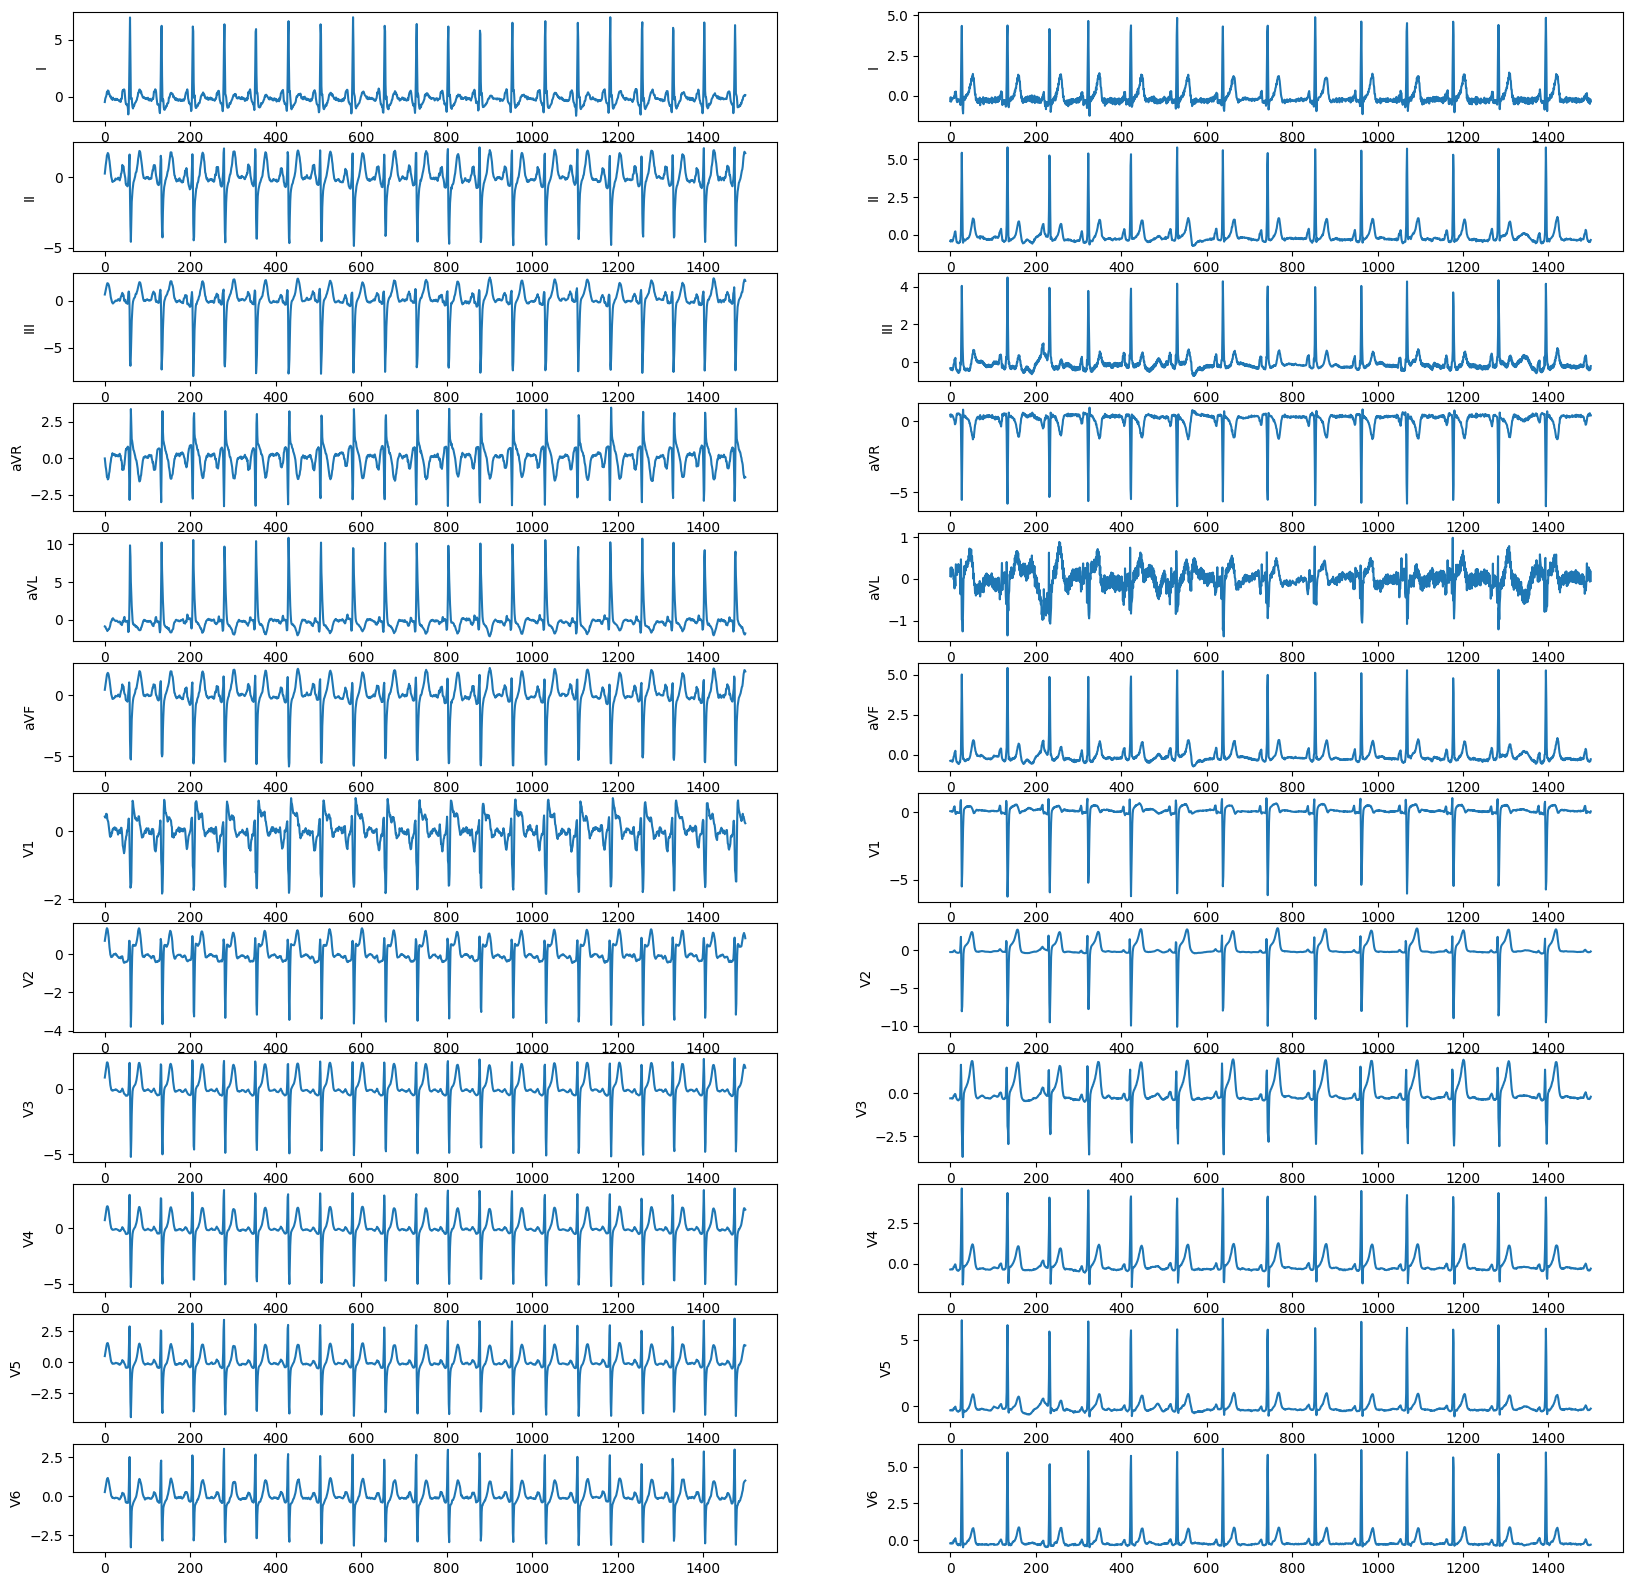

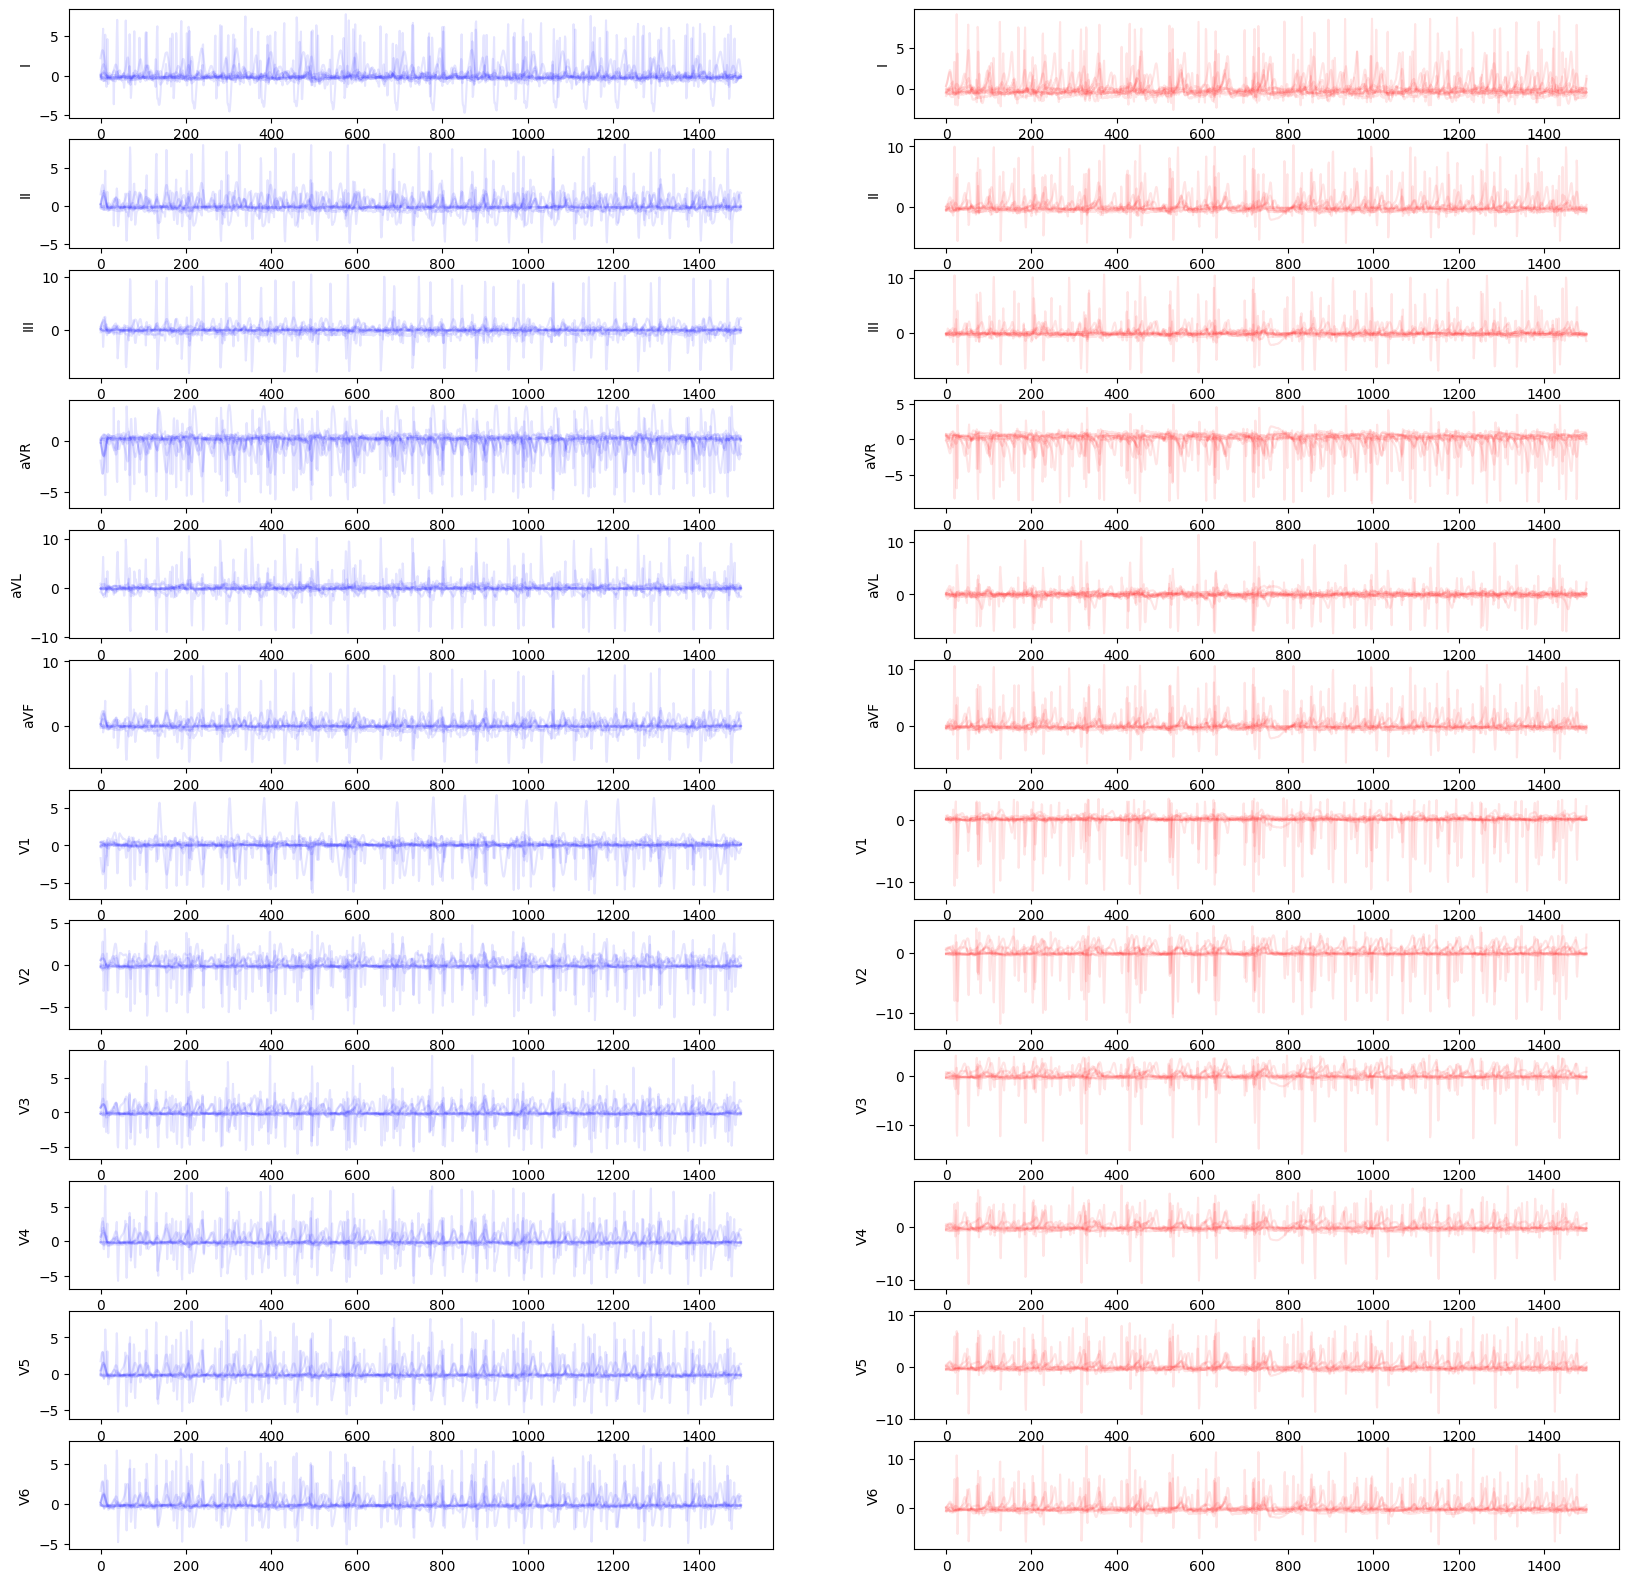

In [18]:
# plot example positive and negative data

fig, ax = plt.subplots(nrows=12, ncols=2, figsize=(20, 20))

for i in range(12):
    ax[i][0].plot(positive_data_norm[0, :, i])
    ax[i][0].set_ylabel(channels[i])
    ax[i][1].plot(negative_data_norm[0, :, i])
    ax[i][1].set_ylabel(channels[i])
    
    # plot all positive and negative data
fig, ax = plt.subplots(nrows=12, ncols=2, figsize=(20, 20))
for i in range(12):
    ax[i][0].plot(positive_data_norm[:, :, i].T, color='blue', alpha=0.1)
    ax[i][0].set_ylabel(channels[i])
    ax[i][1].plot(negative_data_norm[:, :, i].T, color='red', alpha=0.1)
    ax[i][1].set_ylabel(channels[i])
plt.show()

# BARD

In [23]:
import re

def extract_int_from_filename(filename):
    # Use a regular expression to find digits in the filename
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    else:
        raise ValueError("No integer found in the filename.")

In [32]:
def load_ecg(file_path):
    # Read
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    # Initialize the variable to store samples per channel
    samples_per_channel = 0

    # Parse the header to find the "Samples per channel"
    for line in lines:
        if "Samples per channel" in line:
            samples_per_channel = int(line.split(':')[1].strip())
            break
        
        
    # Find the start of the data section
    data_start_idx = 0
    for i, line in enumerate(lines):
        if '[Data]' in line:
            data_start_idx = i + 1
            break
    
    # Extract the data lines
    data_lines = lines[data_start_idx:]
    
    # Parse the data lines into a list of integers
    data = []
    for line in data_lines:
        # Split line by commas and convert to integers
        leads = [int(x) for x in line.split(',') if x.strip() != '']
        leads = leads[:12]
        data.extend(leads)
        
    # format the data into a numpy array
    ecg = np.array(data).reshape(-1, 12)
    truncated_length = (ecg.shape[0] // 1000) * 1000
    truncated_ecg = ecg[:truncated_length]

    ## Downsample to 100hz
    ecg = truncated_ecg.reshape(-1, 10, 12).mean(axis=1)
    
    return ecg

In [33]:
# load the BARD data

positive_bard_files = ['Brugada AI ECG test set/BrS +ve/' + f for f in os.listdir('Brugada AI ECG test set/BrS +ve') if f.endswith('.txt')] 
negative_bard_files = ['Brugada AI ECG test set/BrS -ve/' + f for f in os.listdir('Brugada AI ECG test set/BrS -ve') if f.endswith('.txt')]

print(positive_bard_files)
print(negative_bard_files)

print(len(positive_bard_files))
print(len(negative_bard_files))

['Brugada AI ECG test set/BrS +ve/BRS 61C.txt', 'Brugada AI ECG test set/BrS +ve/BRS 22A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 34B.txt', 'Brugada AI ECG test set/BrS +ve/BRS 40A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 3a.txt', 'Brugada AI ECG test set/BrS +ve/BRS 45A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 48E.txt', 'Brugada AI ECG test set/BrS +ve/BRS 46C.txt', 'Brugada AI ECG test set/BrS +ve/BRS 14A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 54A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 17A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 18B.txt', 'Brugada AI ECG test set/BrS +ve/BRS 15A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 50A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 52A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 30A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 16A.txt', 'Brugada AI ECG test set/BrS +ve/BRS 5a.txt']
['Brugada AI ECG test set/BrS -ve/N9.txt', 'Brugada AI ECG test set/BrS -ve/N13.txt', 'Brugada AI ECG test set/BrS -ve/N5.txt', 'Brugada AI ECG test set/Br

In [34]:

ecgs = []
labels = []
patients = []
files = []

for file in positive_bard_files:
    ecg = load_ecg(file)
    # print(ecg.shape)
    # print(file)
    ecgs.append(ecg)
    patients.append(extract_int_from_filename(file))
    files.append(file)
    labels.append(True)
    
for file in negative_bard_files:
    ecg = load_ecg(file)
    print(ecg.shape)
    print(file)
    if file.endswith('N2.txt'):
        print('Skipping')
        continue
    ecgs.append(ecg)
    patients.append(extract_int_from_filename(file))
    files.append(file)
    labels.append(False)
    
ecgs = np.stack(ecgs, axis=0)
labels = np.array(labels)
patients = np.array(patients)
files = np.array(files)

print(ecgs.shape)
print(labels.shape)
print(patients.shape)
print(files.shape)


(1400, 12)
Brugada AI ECG test set/BrS -ve/N9.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N13.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N5.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N15.txt
(1200, 12)
Brugada AI ECG test set/BrS -ve/N2.txt
Skipping
(1400, 12)
Brugada AI ECG test set/BrS -ve/N6.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N1.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N10.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N14.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N8.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N12.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N7.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N4.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N17.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N18.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N11.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N16.txt
(1400, 12)
Brugada AI ECG test set/BrS -ve/N3.txt
(35, 1400, 12)
(35,)
(35,)
(35,)


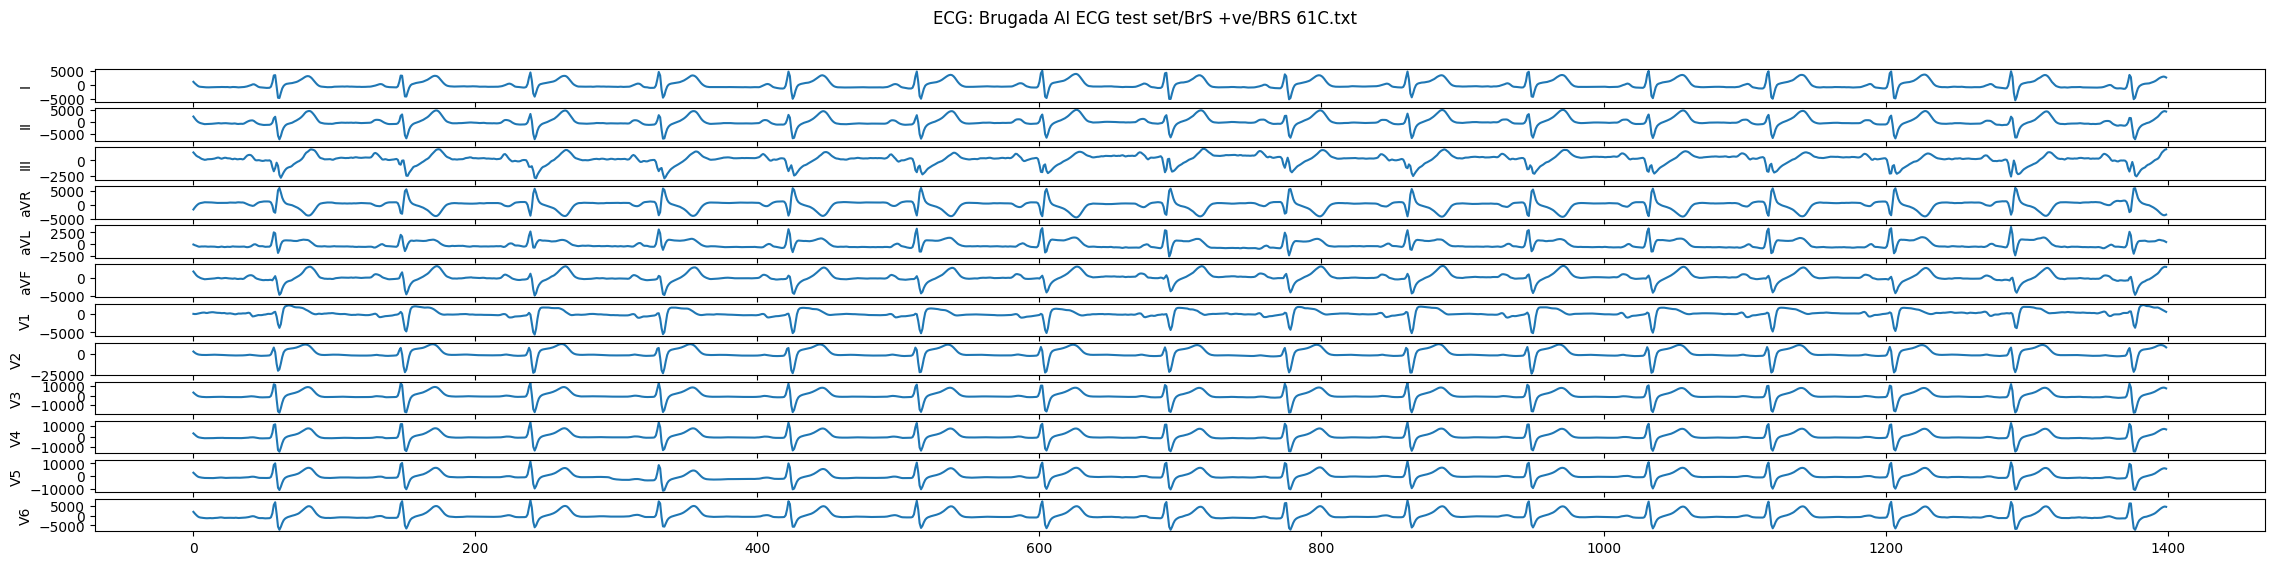

In [36]:
# visualise the BARD data
dv.plot_12_lead_ecg(ecgs[0], files[0])

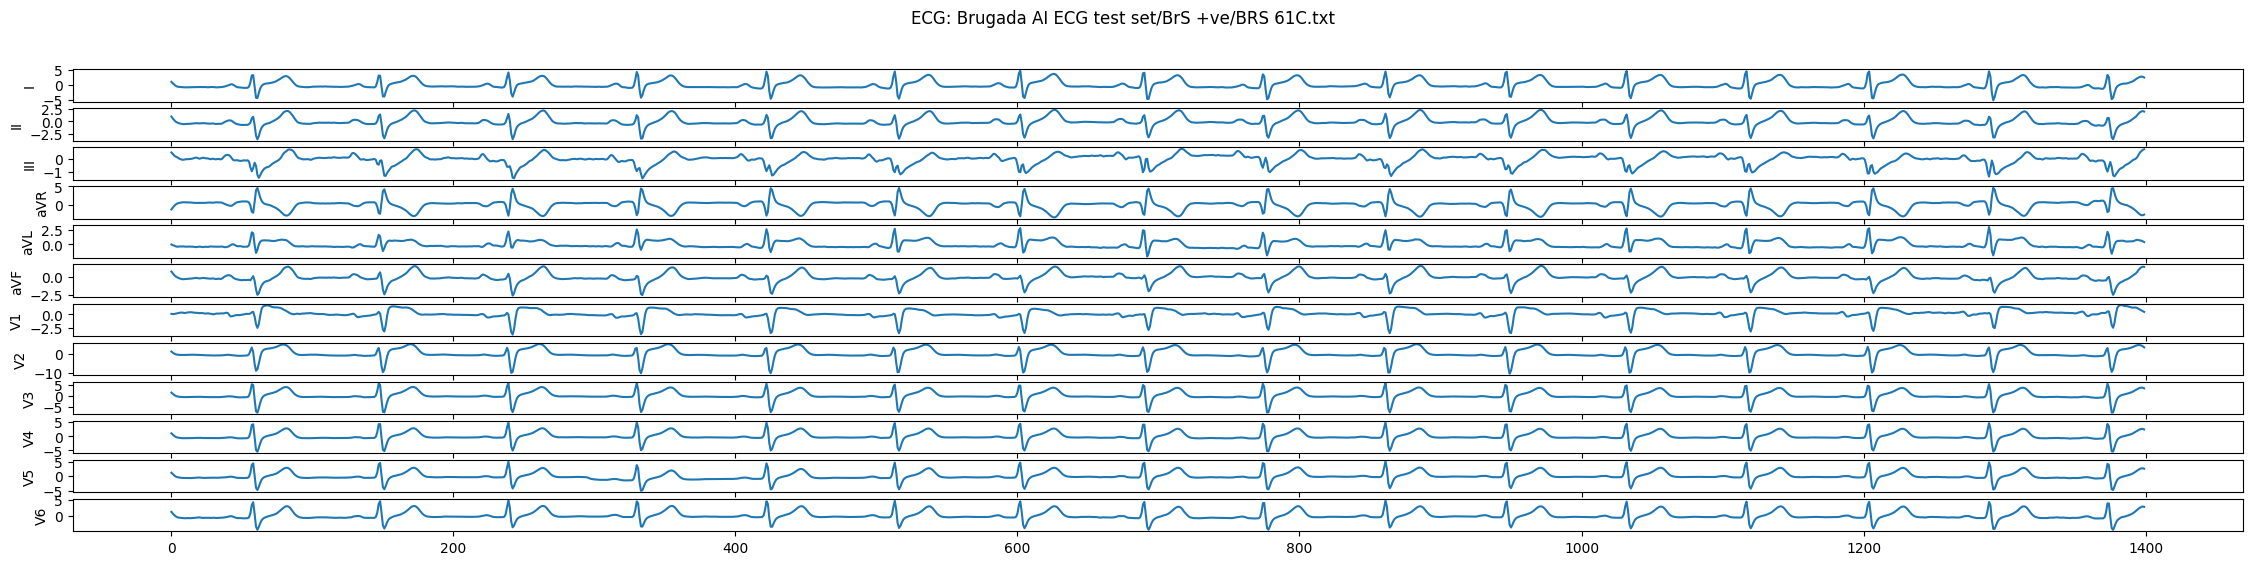

In [37]:
# normalise the BARD data
scaler = StandardScaler()
scaler.fit(np.concatenate(ecgs))

for i in range(len(ecgs)):
    ecgs[i] = scaler.transform(ecgs[i])
    
# visualise the normalised BARD data
dv.plot_12_lead_ecg(ecgs[0], files[0])

In [40]:
print(uhf_data.shape)
print(ecgs.shape)

# save the data in a numpy file
np.savez('extrernal_test_data.npz', uhf_data=uhf_data, uhf_labels=uhf_labels, bard_data=ecgs, bard_labels=labels)

(18, 1500, 12)
(35, 1400, 12)


In [1]:
# load the data
import sys
import numpy as np

thismodule = sys.modules[__name__]

with np.load('extrernal_test_data.npz') as data:
    for key in data:
        setattr(thismodule, key, data[key])
        
print(uhf_data.shape)
print(uhf_labels.shape)
print(bard_data.shape)
print(bard_labels.shape)

(18, 1500, 12)
(18,)
(35, 1400, 12)
(35,)


# Combine + Split into beats

In [3]:
def split_into_beats(X, labels, folds=None, window_size=50):
    ecgs_HB = []
    labels_HB = []
    
    for i, sample in enumerate(X):
        print("Progress:", i, "/", X.shape[0], end="\r")
        xqrs = processing.XQRS(sig=sample[:,0], fs=100)
        xqrs.detect(verbose=False)
        qrs_inds = xqrs.qrs_inds
        for indx in qrs_inds:
            if indx + window_size > sample.shape[0] or indx - window_size < 0:
                continue
            ecgs_HB.append(sample[indx-window_size:indx+window_size])
            labels_HB.append(labels[i])
    
    print()
    return np.array(ecgs_HB), np.array(labels_HB)

# split the BARD data into heartbeats
bard_beats, bard_beats_labels = split_into_beats(bard_data, bard_labels)

# split the UHF data into heartbeats
uhf_beats, uhf_beats_labels = split_into_beats(uhf_data, uhf_labels)

print(bard_beats[0].shape)
print(bard_beats.shape)

print(uhf_beats[0].shape)
print(uhf_beats.shape)

all_beats = np.concatenate([bard_beats, uhf_beats], axis=0)
all_labels = np.concatenate([bard_beats_labels, uhf_beats_labels], axis=0)

# "BARD" = 1 or "UHF" = 0
all_source = np.concatenate([np.ones(bard_beats.shape[0]), np.zeros(uhf_beats.shape[0])])

print(all_beats.shape)
print(all_labels.shape)
print(all_source.shape)



Progress: 34 / 35
Progress: 17 / 18
(100, 12)
(734, 100, 12)
(100, 12)
(369, 100, 12)
(1103, 100, 12)
(1103,)
(1103,)


In [4]:
# save the data in a numpy file

np.savez('extrernal_test_data_beats.npz', all_beats=all_beats, all_labels=all_labels, all_source=all_source)

In [5]:
# load the data
import sys
import numpy as np

thismodule = sys.modules[__name__]

with np.load('extrernal_test_data_beats.npz') as data:
    for key in data:
        setattr(thismodule, key, data[key])

print(all_beats.shape)
print(all_labels.shape)
print(all_source.shape)

(1103, 100, 12)
(1103,)
(1103,)
